In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import collections

from networkx.algorithms import community
import community.community_louvain as community_louvain
import time

In [2]:
%%capture

# check if this is a colab notebook and clone the repo if it is
if 'COLAB_GPU' in os.environ:
    %cd /content/
    !git clone https://github.com/Enver-group/twitch-web-analytics
    %cd twitch-web-analytics
else:
    os.chdir('..')

!pip install -r requirements.txt

!pip install -e .

In [3]:
#autoreload modules
%load_ext autoreload
%autoreload 2

from src.user import User

In [4]:
df = pd.read_feather("data/streamers.feather")

#TODO: put this cell in the code that generates the dataframe

# removing users that have no data about which users they follow
num_users = df.shape[0]
df.dropna(subset=['num_followers'],inplace=True)
print(num_users - df.shape[0], "users have been removed for having null data in num_followers")

# remove from each array with users followed (the arrays that are in 'user_follows') the users that are not in the dataset
df_streamers_exploded = df.explode("user_follows")
num_users_followed = len(df_streamers_exploded["user_follows"].unique())
df_streamers_exploded = df_streamers_exploded[df_streamers_exploded["user_follows"].isin(df.id)]
print(num_users_followed - len(df_streamers_exploded["user_follows"].unique()), "users have been removed from the arrays in 'user_follows'")
user_follows_arrays = df_streamers_exploded.groupby("id").user_follows.apply(np.array).reset_index()
df = df.set_index("id")
df.loc[user_follows_arrays.id,"user_follows"] = user_follows_arrays.user_follows.values
# assign empty arrays to the users removed for not following any user of the dataset
not_in_set_or_null = ~df.index.isin(user_follows_arrays.id)
df.loc[not_in_set_or_null,"user_follows"] =  pd.Series([[]]*not_in_set_or_null.sum()).values
df.reset_index(level=0, inplace=True)
print(not_in_set_or_null.sum(), "users don't follow to any user after applying the previous filters")


81217 users have been removed for having null data in num_followers
74310 users have been removed from the arrays in 'user_follows'
122 users don't follow to any user after applying the previous filters


In [5]:
# converting the df into a graph
G = nx.DiGraph()
for i,user in df.iterrows():
  G.add_node(user["id"], **user.drop(["id","user_follows"]))
  if isinstance(user["user_follows"], np.ndarray):
    G.add_edges_from([(user["id"], id_followed) for id_followed in user["user_follows"]]) 

In [6]:
# checking the correctness of the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges(), "\n")
for i, user in enumerate(G.degree()):
  if i >10:
    break
  print(G.nodes[user[0]]["name"], "is following to", user[1], "users")

Number of nodes: 15460
Number of edges: 1786463 

auronplay is following to 7651 users
josecristo_ is following to 345 users
xXxTheFocuSxXx is following to 579 users
Ampeterby7 is following to 1165 users
javiDMr10 is following to 226 users
gtv_genesis is following to 411 users
Tanizen is following to 898 users
Carola is following to 1421 users
CooLifeGame is following to 1871 users
Luzu is following to 1664 users
ZormanWorld is following to 587 users


In [7]:
# # another approach creating the graph from the exploded df (TODO: understand why the result is not equivalent)

# df_streamers = pd.read_feather("data/streamers.feather")
# df_streamers.dropna(subset=['num_followers'],inplace=True)
# edges = df_streamers.explode("user_follows")[["id","user_follows"]]
# edges = edges[edges["user_follows"].isin(df_streamers.id)]

# G = nx.from_pandas_edgelist(edges, 'id', 'user_follows')
# for col_name in df_streamers.drop(['id', 'user_follows'], axis=1):
#   nx.set_node_attributes(G, pd.Series(df_streamers[col_name], index=df_streamers["id"]).to_dict(), col_name)

# print("Number of nodes:", G.number_of_nodes())
# print("Number of edges:", G.number_of_edges(), "\n")
# for i, user in enumerate(G.degree()):
#   if i >10:
#     break
#   print(G.nodes[user[0]]["name"], "is following to", user[1], "users")


## Graph analysis: Fundamental metrics

In [8]:
# compute fundamental metrics(or load if they'be been already computed)

metrics = {"indegree":nx.in_degree_centrality, "outdegree":nx.out_degree_centrality, "closeness":nx.closeness_centrality, 
            "betweenness":nx.betweenness_centrality, "pagerank":nx.pagerank, "nx_cores":nx.algorithms.core.core_number}

# create folder to save the metrics if needed
folder_name = "data/fundamental_metrics"
if not os.path.exists(folder_name):
  os.mkdir(folder_name)

for m in metrics:
  file_name = f"{folder_name}/{m}.pkl"
  if os.path.exists(file_name):
    # load metric
    with open(file_name, 'rb') as f:
      metrics[m] = pickle.load(f)
  else:
    # compute metric
    computed_metric = metrics[m](G)
    # sort metric from highest to lowest
    metrics[m] = dict(sorted(computed_metric.items(), key=lambda x: x[1],reverse=True))
    # store metric
    with open(file_name, 'wb') as f:
        pickle.dump(metrics[m], f)
  # display 10 first items of metric
  print(f"\n{m}:", dict(list(metrics[m].items())[:10]))



indegree: {'83232866': 0.6508182935506824, '39276140': 0.5459602820363542, '459331509': 0.49214050067921594, '48878319': 0.40798240507147937, '36473331': 0.3053237596222265, '31919607': 0.2773141859111197, '512977322': 0.26476486189274856, '57793021': 0.23442654764215018, '123922797': 0.2291868814282942, '70357283': 0.22899281971666988}

outdegree: {'42219929': 0.07671906332880522, '488187640': 0.06772753735687949, '562498092': 0.06546348405459602, '134196130': 0.06384630312439356, '134913602': 0.062164434956982983, '545338107': 0.061323500873277696, '513136957': 0.0611941263988615, '76491680': 0.06009444336632382, '142953848': 0.06002975612911572, '488395038': 0.05957694546865903}

closeness: {'83232866': 0.7355616756504315, '39276140': 0.6811549588143192, '459331509': 0.6558279703099003, '48878319': 0.6190074031306253, '36473331': 0.575518958123038, '31919607': 0.5701023598820509, '512977322': 0.5610147166412464, '57793021': 0.5546902530351849, '123922797': 0.553841608469125, '12151

In [9]:
#obtain per each metric 10 nodes with the highest values
df_ranking_metrics = pd.DataFrame()
for m in metrics:
  ranking10_ids = list(metrics[m].keys())[:10]
  ranking10_names = [G.nodes[node_id]["name"] for node_id in ranking10_ids]
  df_ranking_metrics[m] = ranking10_names
print("Graph fundamental metrics:")

df_ranking_metrics

Graph fundamental metrics:


,indegree,outdegree,closeness,betweenness,pagerank,nx_cores
0,ibai,malaso,ibai,coscu,ibai,auronplay
1,Rubius,elcondu,Rubius,TELLIER50,Rubius,ibai
2,auronplay,Morita,auronplay,TheGrefg,auronplay,TheGrefg
3,TheGrefg,GuadaLibrandi,TheGrefg,Magi,TheGrefg,Rubius
4,coscu,CEDROLAA,coscu,DuendePablo,elxokas,ElSpreen
5,elxokas,dykahok,elxokas,IamCristinini,IlloJuan,SLAKUN10
6,SLAKUN10,helicopptero,SLAKUN10,juansguarnizo,LVPes,Robleis
7,LOLITOFDEZ,ramilueso,LOLITOFDEZ,Rubius,alexelcapo,iaaraS2
8,IamCristinini,joaquinpelaez,IamCristinini,Sibrel,IamCristinini,Agusbob
9,AriGameplays,Sebita,juansguarnizo,ibai,coscu,MarkitoNavaja


In [13]:
# compute k-core descomposition
nx_cores = metrics["nx_cores"]
print("\nFirst 10 users with the cores given by NetworkX:\n", dict(list(nx_cores.items())[:10]))

# reformat NetworkX solution
nx_cores_format = {c:set() for c in set(nx_cores.values())}
for node in nx_cores:
  nx_cores_format[nx_cores[node]].add(node)
print("\nFirst 10 cores with their users associated:\n", dict(list(nx_cores_format.items())[:10]))

highest_core = list(nx_cores.values())[0]
print("\nThe highest core number is", highest_core)
print("\50 random users that have the highest core are:")
users_highset_core = []
for node_id in list(nx_cores_format[highest_core])[:50]:
  user_name = G.nodes[node_id]["name"]
  users_highset_core.append(user_name)
  print(user_name, end=", ")


First 10 users with the cores given by NetworkX:
 {'459331509': 267, '83232866': 267, '48878319': 267, '39276140': 267, '157658336': 267, '512977322': 267, '199811071': 267, '142932807': 267, '94851664': 267, '494026769': 267}

First 10 cores with their users associated:
 {0: {'468612220', '43781156'}, 1: {'724679930', '620773811'}, 2: {'149613744', '726605857'}, 3: {'442505580', '138218530', '721811548', '21673408', '439373923', '20619890'}, 4: {'61113472', '52962872', '605649930'}, 5: {'23555970', '689150831', '117637690', '236190404', '417505906', '455809385', '632828507', '97744631', '447417600', '43062679', '547377613', '500164492'}, 6: {'400033906', '670484955', '664056787', '99286454', '32698492', '43898453'}, 7: {'57336109', '66577316', '716049080', '156797648', '592914032', '568236442', '202442955', '612418652', '71595808', '112100325', '105915313', '610101640', '157898671', '42386491', '714653105', '98798251'}, 8: {'418106408', '97144135', '55480030', '162503630', '52611408'

The 10  most frequent users in the rankings of the previous metrics (ordered by freq) are:
ibai, Rubius, TheGrefg, auronplay, coscu, IamCristinini, elxokas, SLAKUN10, LOLITOFDEZ, juansguarnizo, AriGameplays


Previous users ordered by core number:

With core number 267:
TheGrefg, coscu, Rubius, SLAKUN10, auronplay, ibai

With core number 262:
IamCristinini

With core number 260:
LOLITOFDEZ

With core number 251:
elxokas, AriGameplays

With core number 237:
juansguarnizo


([<matplotlib.patches.Wedge at 0x7f730d731350>,
 [Text(-1.0888035780743386, -0.1565463777048765, '267'),
  Text(0.5947050015941456, -0.9253788203103135, '262'),
  Text(1.0005952532309026, -0.45695638655323106, '260'),
  Text(1.0005951248808298, 0.4569566676006785, '251'),
  Text(0.309905623873715, 1.0554423263691122, '237')],
 [Text(-0.593892860767821, -0.085388933293569, '54.5%'),
  Text(0.32438454632407937, -0.5047520838056254, '9.1%'),
  Text(0.5457792290350377, -0.2492489381199442, '9.1%'),
  Text(0.545779159025907, 0.24924909141855187, '18.2%'),
  Text(0.16903943120384451, 0.5756958143831521, '9.1%')])

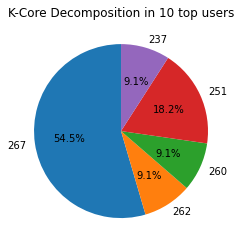

In [21]:
# order the imporant users (according to fundamental metrics) by core number
important_users_names = collections.Counter()
for m in df_ranking_metrics.drop("outdegree", axis=1):
  for user_name in df_ranking_metrics[m]:
    important_users_names.update([user_name,])
# order counter
print("The 10  most frequent users in the rankings of the previous metrics (ordered by freq) are:")
important_users_names = [i[0] for i in important_users_names.most_common()][:11]
print(", ".join(important_users_names))
# extract ids from important users
important_users_ids = list(df[df["name"].isin(important_users_names)]["id"])

important_users_cores = { user_id: nx_cores[user_id] for user_id in important_users_ids}
# reformat NetworkX solution
important_users_cores_format = {c:set() for c in set(important_users_cores.values())}
for node in important_users_cores:
  important_users_cores_format[important_users_cores[node]].add(node)
important_users_cores_format = dict(sorted(important_users_cores_format.items(), key=lambda x: x[0],reverse=True))

n_important_users = len(important_users_ids)
cores = []
percentage_cores = []
print("\n\nPrevious users ordered by core number:")
for core in important_users_cores_format:
  cores.append(core)
  users_in_core = [G.nodes[node_id]["name"] for node_id in important_users_cores_format[core]]
  percentage_cores.append(len(users_in_core)/n_important_users)
  print(f"\nWith core number {core}:")
  print(", ".join([G.nodes[node_id]["name"] for node_id in important_users_cores_format[core]]))

plt.title("K-Core Decomposition in 10 top users")
plt.pie(percentage_cores, labels=list(important_users_cores_format.keys()), autopct='%1.1f%%',
        startangle=90)

# plt.show()
# plt.plot(np.arange(len(nx_cores_format.keys())), [len(i) for i in nx_cores_format.values()])
# plt.xlabel('Cores')
# plt.ylabel('Number of streamers')
# plt.title('Programming language usage')


In [29]:
# order the imporant users (according to fundamental metrics) by core number
important_users_names = set()
for m in df_ranking_metrics.drop("outdegree", axis=1):
  for user_name in df_ranking_metrics[m]:
    important_users_names.add(user_name)
print("The users that appear one or more times in the rankings of the previous metrics are:")
print(", ".join(important_users_names))
# extract ids from important users
important_users_ids = list(df[df["name"].isin(important_users_names)]["id"])

important_users_cores = { user_id: nx_cores[user_id] for user_id in important_users_ids}
# reformat NetworkX solution
important_users_cores_format = {c:set() for c in set(important_users_cores.values())}
for node in important_users_cores:
  important_users_cores_format[important_users_cores[node]].add(node)
important_users_cores_format = dict(sorted(important_users_cores_format.items(), key=lambda x: x[0],reverse=True))

print("\n\nPrevious users ordered by core number:")
for core in important_users_cores_format:
  print(f"\nWith core number {core}:")
  print(", ".join([G.nodes[node_id]["name"] for node_id in important_users_cores_format[core]]))

The users that appear one or more times in the rankings of the previous metrics are:
elxokas, AriGameplays, TELLIER50, alexelcapo, IamCristinini, TheGrefg, Magi, LOLITOFDEZ, ibai, juansguarnizo, DuendePablo, IlloJuan, coscu, LVPes, Sibrel, SLAKUN10, auronplay, Rubius


Previous users ordered by core number:

With core number 267:
TheGrefg, auronplay, DuendePablo, SLAKUN10, Rubius, ibai, coscu, TELLIER50

With core number 262:
IamCristinini

With core number 260:
LOLITOFDEZ

With core number 251:
AriGameplays, elxokas

With core number 237:
juansguarnizo

With core number 223:
LVPes

With core number 207:
alexelcapo

With core number 188:
IlloJuan

With core number 166:
Sibrel

With core number 164:
Magi


In [12]:
# compute the position in pagerank for an especific user
streamer_name = input("Enter the name of the user: ") # e.g. DavimenXPro
streamer_id = str(int(df.loc[df["name"]==streamer_name]["id"]))
position = list(metrics["pagerank"].keys()).index(streamer_id)

print(f"Position on pagerank of {streamer_name}: {position+1} of {len(df)}")

Enter the name of the user: DavimenXPro
Position on pagerank of DavimenXPro: 15412 of 15460


## Graph analysis: Community detection

In [22]:
# compute communities with louvain method considering the directed graph as undirected
G_undirected = nx.Graph(G)
# compute communities
start = time.time()
communities_unformat = community_louvain.best_partition(G_undirected)
end = time.time()
# transform communities into appropiate format if necessary
communities = [set() for i in range(len(set(communities_unformat.values())))]
for c in communities_unformat:
  communities[communities_unformat[c]].add(c)
# compute modularity
modularity = community.modularity(G_undirected,communities)

print("Time of execution:", end-start)
print("Modularity:",modularity)

Time of execution: 50.67910838127136
Modularity: 0.4553548316094837
